Trellis Coded Quantizer (TCQ) forward pass

reference:

https://en.wikipedia.org/wiki/Viterbi_algorithm

https://www.sfu.ca/~jiel/courses/861/slides.html

In [2]:
import numpy
import torch

In [3]:
def viterbi(quant_errors, states, start_p, trans_p, Codebook, x, training):
  V = [{}]
  for st in states:
    V[0][st] = {"val": start_p[st], "prev": None, "branch_id": None}

  h,w = x.size()
  # Run Viterbi when t>1
  for t in range(1, w+1):
    V.append({})
    for i,st in enumerate(states):
      val_all = [] # max length is 2 actually
      states_all = []
      branch_id_all = []
      for j in range(len(trans_p[:][i])):
        if trans_p[j][i] is not None:
          dist_min = numpy.amin(quant_errors[trans_p[j][i]][:,:,t-1],axis=0)
          branch_id = numpy.argmin(quant_errors[trans_p[j][i]][:,:,t-1],axis=0)
          ss = [states[j] for pp in range(h)]
          val_all.append(V[t-1][states[j]]["val"]+dist_min)
          states_all.append(ss)
          branch_id_all.append(branch_id)
      min_val = numpy.amin(numpy.array(val_all),axis=0) # min_val:h
      min_ind = numpy.argmin(numpy.array(val_all),axis=0)
      prev_st = numpy.array(states_all)[min_ind,range(h)]
      branch_id = numpy.array(branch_id_all)[min_ind,range(h)]

      V[t][st] = {"val": min_val, "prev": prev_st, "branch_id": branch_id}

  opt_path = [] # optimal path
  opt_indices = []
  val_last = [value["val"] for value in V[-1].values()]#val_last: 4,h
  minn_val = numpy.amin(numpy.array(val_last),axis=0)# minn_val: h
  minn_inds = numpy.argmin(numpy.array(val_last),axis=0)# minn_inds: h
  previous = None

  # Get minimum distortion and its backtrack
  #V_states = numpy.array(['11','10','00','01']) # python2
  V_states = numpy.array(['00', '01','10','11']) # python3
  temp_state = V_states[minn_inds]

  #temp_state = [V_states[s] for ss,s in enumerate(minn_inds)]
  opt_path.append(temp_state)
  temp_inds_branch = [r[0] for r in temp_state] # h
  temp_inds_last = [V[-1][V_states[s]]["branch_id"][ss] for ss,s in enumerate(minn_inds)] # h
  opt_indices.append(numpy.column_stack((temp_inds_branch,temp_inds_last))) # h,bit+1
  previous = temp_state

  # Follow the backtrack till the first state
  for t in range(len(V)-2,-1,-1):
    temp_state1 = [V[t+1][s]["prev"][ss] for ss,s in enumerate(previous)]
    opt_path.insert(0, temp_state1)
    if t != 0:
      temp_inds_branch1 = [r[0] for r in temp_state1]
      temp_inds_last1 = [V[t][V[t+1][s]["prev"][ss]]["branch_id"][ss] for ss,s in enumerate(previous)]
      opt_indices.insert(0,numpy.column_stack((temp_inds_branch1,temp_inds_last1)))
    previous = temp_state1

  # note indices R-1 bit is interger, not convert bit symbol yet
  # decoder to get x_hat
  x_hat = numpy.copy(x)
  for i in range(len(opt_path)-1):
    ind_start = list(map(lambda x: int(x,2), opt_path[i]))
    ind_end = list(map(lambda x: int(x,2), opt_path[i+1]))
    decode = list(map(lambda x: Codebook[x],numpy.array(trans_p)[ind_start,ind_end]))
    lala = list(map(lambda x: int(x), opt_indices[i][:,1]))
    x_hat[:,i] = numpy.array(decode)[range(h),numpy.array(lala)]

  #### use index to represent the codes for quantized feature map
  codebook_inds = {
              'D0': [0,2],
              'D1': [0,2],
              'D2': [1,3],
              'D3': [1,3]
               }
  opt_indices_union = numpy.copy(x)
  if not training:
    for i in range(len(opt_path)-1):
      ind_start = list(map(lambda x: int(x,2), opt_path[i]))
      ind_end = list(map(lambda x: int(x,2), opt_path[i+1]))
      decode_union = list(map(lambda x: codebook_inds[x],numpy.array(trans_p)[ind_start,ind_end]))
      lala = list(map(lambda x: int(x), opt_indices[i][:,1]))
      opt_indices_union[:,i] = numpy.array(decode_union)[range(h),numpy.array(lala)]
  return x_hat, opt_indices_union


In [4]:
# test for 4-state trellis
# input data
x = torch.Tensor([[-4.1, 2.2, 0.3, -2.5]])
h,w = x.size()
#x = [-4.1, 2.2, 0.3, -2.5]
# R=2bit/sample
states = ('00', '01','10','11')
# initiaalization
start_p = {'00': 0, '01': 0, '10': 0, '11': 0}
# define transition diagram
trans_p = [
   ['D0', None, 'D2', None],
   ['D2', None, 'D0', None],
   [None, 'D1', None,'D3'],
   [None, 'D3', None, 'D1']
]
Codebook = {
    'D0': [-7, 1],
    'D1': [-5, 3],
    'D2': [-3, 5],
    'D3': [-1, 7]
}

quant_errors = {}
x1 = x.view(1,h,w).repeat(len(Codebook['D0']),1,1) # d,h,w
quant_errors['D0']=((x1-torch.Tensor(Codebook['D0']).view(-1,1,1).repeat(1,h,w))**2).numpy()
quant_errors['D1']=((x1-torch.Tensor(Codebook['D1']).view(-1,1,1).repeat(1,h,w))**2).numpy()
quant_errors['D2']=((x1-torch.Tensor(Codebook['D2']).view(-1,1,1).repeat(1,h,w))**2).numpy()
quant_errors['D3']=((x1-torch.Tensor(Codebook['D3']).view(-1,1,1).repeat(1,h,w))**2).numpy()

x_hat, opt_indices_union = viterbi(quant_errors, states, start_p, trans_p, Codebook, x, False)
print(x_hat)
print(opt_indices_union)

[[-5.  3. -1. -3.]]
[[0. 2. 1. 1.]]


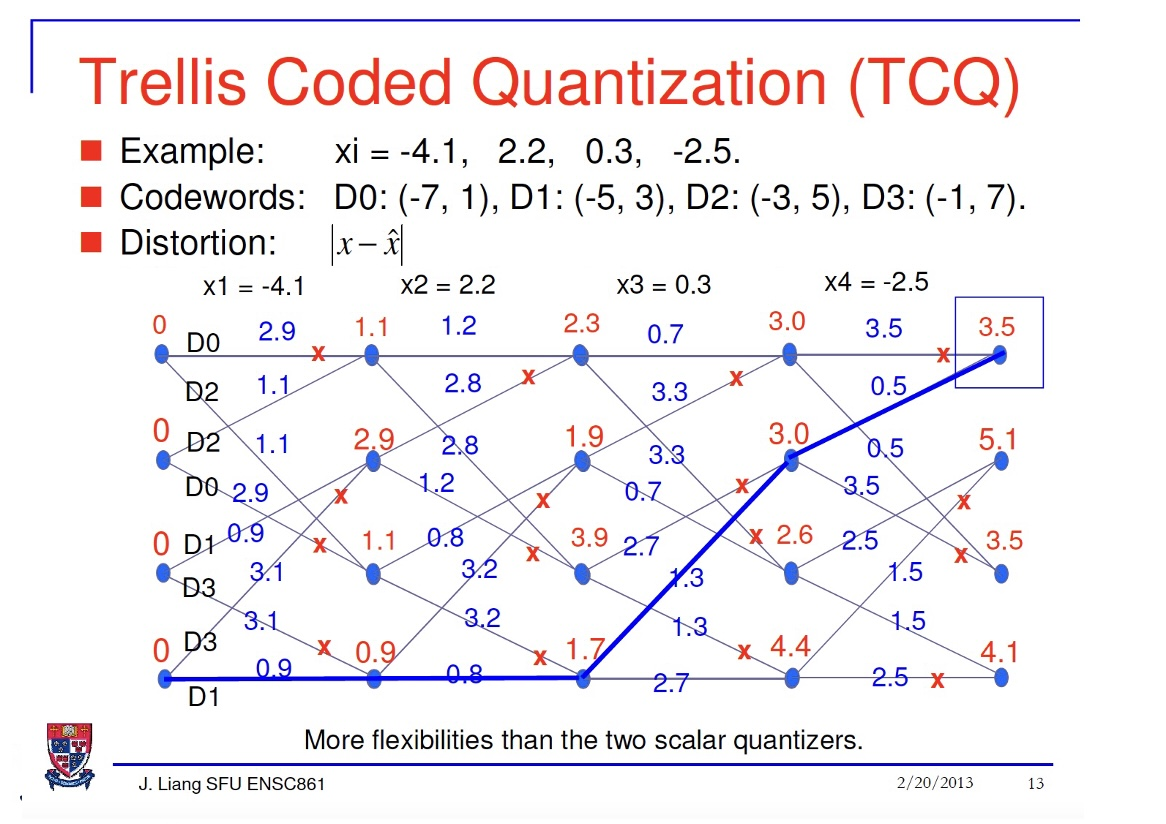

In [11]:

def viterbi(quant_errors, states, start_p, trans_p, Codebook, x, training):
  V = [{}]
  for st in states:
    V[0][st] = {"val": start_p[st], "prev": None, "branch_id": None}

  h,w = x.size()
  # Run Viterbi when t>1
  for t in range(1, w+1):
    V.append({})
    for i,st in enumerate(states):
      val_all = [] # max length is 2 actually
      states_all = []
      branch_id_all = []
      for j in range(len(trans_p[:][i])):
        if trans_p[j][i] is not None:
          dist_min = numpy.amin(quant_errors[trans_p[j][i]][:,:,t-1],axis=0)
          branch_id = numpy.argmin(quant_errors[trans_p[j][i]][:,:,t-1],axis=0)
          ss = [states[j] for pp in range(h)]
          val_all.append(V[t-1][states[j]]["val"]+dist_min)
          states_all.append(ss)
          branch_id_all.append(branch_id)
      min_val = numpy.amin(numpy.array(val_all),axis=0) # min_val:h
      min_ind = numpy.argmin(numpy.array(val_all),axis=0)
      prev_st = numpy.array(states_all)[min_ind,range(h)]
      branch_id = numpy.array(branch_id_all)[min_ind,range(h)]

      V[t][st] = {"val": min_val, "prev": prev_st, "branch_id": branch_id}

  opt_path = [] # optimal path
  opt_indices = []
  val_last = [value["val"] for value in V[-1].values()]
  minn_val = numpy.amin(numpy.array(val_last),axis=0)
  minn_inds = numpy.argmin(numpy.array(val_last),axis=0)
  previous = None

  # Get minimum distortion and its backtrack
  V_states = numpy.array(['000', '001', '010', '011', '100','101','110','111']) # python3
  temp_state = V_states[minn_inds]

  opt_path.append(temp_state)
  temp_inds_branch = [r[0] for r in temp_state]
  temp_inds_last = [V[-1][V_states[s]]["branch_id"][ss] for ss,s in enumerate(minn_inds)]
  opt_indices.append(numpy.column_stack((temp_inds_branch,temp_inds_last)))
  previous = temp_state

  # Follow the backtrack till the first state
  for t in range(len(V)-2,-1,-1):
    temp_state1 = [V[t+1][s]["prev"][ss] for ss,s in enumerate(previous)]
    opt_path.insert(0, temp_state1)
    if t != 0:
      temp_inds_branch1 = [r[0] for r in temp_state1]
      temp_inds_last1 = [V[t][V[t+1][s]["prev"][ss]]["branch_id"][ss] for ss,s in enumerate(previous)]
      opt_indices.insert(0,numpy.column_stack((temp_inds_branch1,temp_inds_last1)))
    previous = temp_state1

  # note indices R-1 bit is interger, not convert bit symbol yet
  # decoder to get x_hat
  x_hat = numpy.copy(x)
  for i in range(len(opt_path)-1):
    ind_start = list(map(lambda x: int(x,2), opt_path[i]))
    ind_end = list(map(lambda x: int(x,2), opt_path[i+1]))
    decode = list(map(lambda x: Codebook[x],numpy.array(trans_p)[ind_start,ind_end]))
    lala = list(map(lambda x: int(x), opt_indices[i][:,1]))
    x_hat[:,i] = numpy.array(decode)[range(h),numpy.array(lala)]
  return x_hat

# test for 8-state trellis
x = torch.Tensor([[0.8, 7.2, 10.4, -13.6]])
# x = [0.8, 7.2, 10.4, -13.6]
h,w = x.size()
# R=3bit/sample
states = ('000', '001', '010', '011', '100','101','110','111')
start_p = {'000': 0, '001': 0, '010': 0, '011':0,'100': 0, '101': 0, '110': 0, '111':0}
trans_p = [
   ['D0', None, None, None, 'D2', None, None, None],
   ['D2', None, None, None, 'D0', None, None, None],
   [None, 'D1', None, None, None, 'D3', None, None],
   [None, 'D3', None, None, None, 'D1', None, None],
   [None, None, 'D2', None, None, None, 'D0', None],
   [None, None, 'D0', None, None, None, 'D2', None],
   [None, None, None, 'D3', None, None, None, 'D1'],
   [None, None, None, 'D1', None, None, None, 'D3']
]
Codebook = {
    'D0': [-16,-8,0,6,14],
    'D1': [-14,-6,0,8],
    'D2': [-12,-4,2,10],
    'D3': [-10,-2,4,12]
}

quant_errors = {}
x0 = x.view(1,h,w).repeat(len(Codebook['D0']),1,1) # d,h,w
x1 = x.view(1,h,w).repeat(len(Codebook['D1']),1,1) # d,h,w
quant_errors['D0']=((x0-torch.Tensor(Codebook['D0']).view(-1,1,1).repeat(1,h,w))**2).numpy()
quant_errors['D1']=((x1-torch.Tensor(Codebook['D1']).view(-1,1,1).repeat(1,h,w))**2).numpy()
quant_errors['D2']=((x1-torch.Tensor(Codebook['D2']).view(-1,1,1).repeat(1,h,w))**2).numpy()
quant_errors['D3']=((x1-torch.Tensor(Codebook['D3']).view(-1,1,1).repeat(1,h,w))**2).numpy()

x_hat = viterbi(quant_errors, states, start_p, trans_p, Codebook, x, False)
print(x_hat)


[[  0.   8.  10. -14.]]
